In [1]:
# RESOURCES
# M/M/1 Sim https://github.com/sarthak0120/M-M-1-Queue-Simulation/blob/master/Queue%20Simulation.py
# M/M/c Calc https://github.com/HankerZheng/Basic-Calculator-for-Queueing-Theory/blob/master/MMcQueue.py

In [2]:
# mdp tutorial
import numpy as np
import operator

# m/m/c calculator
import math

# m-m-1 simulator
import queue
import copy
import matplotlib.pyplot as plt

In [22]:
# TODO:
# * consider using cupy for gpu acceleration
# * consider using generators, see https://wiki.python.org/moin/Generators


class Error(Exception):
    pass

class ServerMaxCapError(Error):
    def __init__(self, expression, message):
        self.expression = expression
        self.message = message
        
class ServerMinCapError(Error):
    def __init__(self, expression, message):
        self.expression = expression
        self.message = message
        
class Job():
    def __init__(self, arrival_timeslot):
        self._arrival_timeslot = arrival_timeslot
    @property
    def arrival_timeslot(self):
        return self._arrival_timeslot

class QueueSimulator():
    def __init__(self, arrival_rate, departure_rate, simulation_time, max_server_number_cap=100):
        self._arrival_rate = arrival_rate
        self._departure_rate = departure_rate
        self._simulation_time = simulation_time
        self._max_server_number_cap = max_server_number_cap
        # server_num: dynamic value
        self._server_num = 1
        # rho: lambda / miu * servers
        self._rho = self._update_rho()
        # incoming jobs: index i represents timeslot i, value[i] represents the number of jobs 
        self._incoming_jobs = np.random.poisson(arrival_rate, simulation_time)
        # service time: index i represents service time for i-esimo job
        self._service_time = np.random.exponential(1 / departure_rate, self._incoming_jobs.sum())
        self._terminated_jobs = 0
        self._simulation_timeslot = 0
        self._queue = queue.Queue()
        # server_time: lista contenente N elementi, ogni elemento indica l'utilizzo (in frazione di timeslot) del server
        # [0, 1, 0.5] indica che il primo server è occupato per tutto il timeslot, il secondo è idle, il terzo è occupato per metà timeslot
        self._server_time = [1.0]
        
    def _update_rho(self):
        self._rho = self._arrival_rate / (self._departure_rate * self._server_num)
        return self._rho
    
    def plot_incoming_jobs(self):
        %matplotlib notebook
        plt.bar(range(self._simulation_time), self._incoming_jobs)
        #count, bins, ignored = plt.hist(range(self._simulation_time), self._incoming_jobs)
        plt.show()
        
    """
    func allocate_server returns rho if success, otherwise raise ServerMaxCapError 
    """
    def allocate_server(self, count=1):
        if self._server_num + count > self._max_server_number_cap:
            raise ServerMaxCapError('Max Cap Limit Reached', 
                                      'Unable to allocate {self._server_num + count} servers; max cap is {self._max_server_number_cap}')
        self._server_num += count
        self._server_time.append(1.0)
        return self._update_rho()
    
    """
    func deallocate_server returns rho if success, otherwise raise ServerMinCapError 
    """
    def deallocate_server(self, count=1):
        if self._server_num - count < 1:
            raise ServerMinCapError('Min Cap Limit Reached',
                                   'Unable to deallocate to {self._server_num + count} servers; min cap is 1')
        self._server_num -= count
        # fixme: dovresti deallocare una vm idle, altrimenti perdi il job in esecuzione!!
        #        e quindi gestire il problema (ritardare la deallocazione) se non trovi vm idle
        self._server_time.pop()
        return self._update_rho()
    
    # this can be (probably) huge optimized
    def simulate_timeslot(self, verbose=False):
        # estrarre 1 elemento da self._incoming_jobs (numero di job arrivati in un timeslot)
        # possono lavorare N server in parallelo
        if self._incoming_jobs.size > 0:
            job_num = self._incoming_jobs[0]
            self._incoming_jobs = np.delete(self._incoming_jobs, 0) # cancella il primo elemento
            # aggiungi alla coda gli n job ricevuti in questo time slot
            j = Job(self._simulation_timeslot)
            for i in range(job_num):
                self._queue.put(j)
                if verbose:
                    print(f"At timeslot {self._simulation_timeslot} the queue has {self._queue.qsize()} pending job")
                
            # se ci sono server liberi, che prendano un task in carico!
            for i in range(self._server_num):
                if verbose:
                    print(f"Server[{i}] in execution (current timeslot {self._simulation_timeslot})")
                if self._server_time[i] > 0: # server con tempo utile :)
                    # NB. in un timeslot posso potenzialmente processare più job in un timeslot
                    while(self._server_time[i] > 0):
                        if verbose:
                            print(f"Server[{i}] has {self._server_time[i] * 100}% of the timeslot free")

                        # estraggo un job dalla coda
                        # ottenere delle statistiche empiriche(?), es. tempo in coda di questo task
                        try:
                            tmp = self._queue.get(False)
                        except queue.Empty:
                            pass
                        
                        # estraggo un service time, il server ci impiegerà quel tempo per processare il job
                        # quindi il tempo utile in _server_time[i] diminuisce
                        self._server_time[i] -= self._service_time[0]
                        self._service_time = np.delete(self._service_time, 0)
                        self._terminated_jobs += 1
        
            self._simulation_timeslot += 1
            # il tempo è passato, dò un timeslot a tutti i server
            for i in range(self._server_num):
                self._server_time[i] += 1
                if verbose:
                    print(f"Server[{i}] ha server_time {self._server_time[i]}")
        
        return (self._terminated_jobs, self._queue.qsize())


<IPython.core.display.Javascript object>


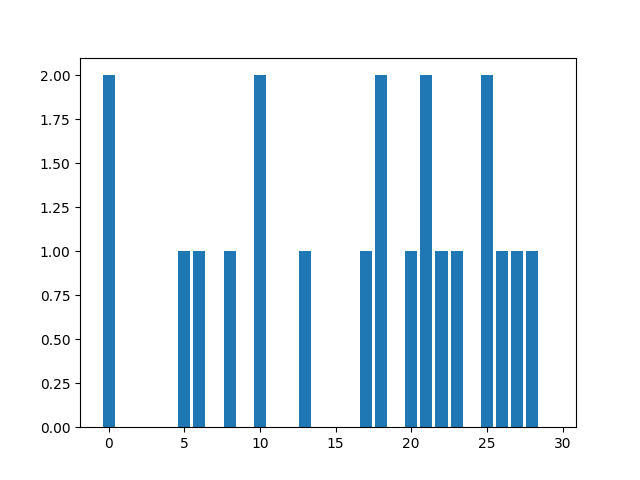

In [24]:
q = QueueSimulator(1, 30, 30, 5)
q.plot_incoming_jobs()

In [25]:
for i in range(29):
    total_job_done, queue_size = q.simulate_timeslot(verbose=True)
    print(f"# total job done: {total_job_done}, current queue size: {queue_size}")

At timeslot 0 the queue has 1 pending job
At timeslot 0 the queue has 2 pending job
Server[0] in execution (current timeslot 0)
Server[0] has 100.0% of the timeslot free
Server[0] has 99.17143359885104% of the timeslot free
Server[0] has 97.70033172673452% of the timeslot free
Server[0] has 86.38364979705784% of the timeslot free
Server[0] has 84.9254088116243% of the timeslot free
Server[0] has 83.30123993223572% of the timeslot free
Server[0] has 80.63452573456628% of the timeslot free
Server[0] has 79.6394971836748% of the timeslot free
Server[0] has 74.07817843572724% of the timeslot free
Server[0] has 69.56103653492492% of the timeslot free
Server[0] has 67.38529084543873% of the timeslot free
Server[0] has 66.53872993326011% of the timeslot free
Server[0] has 63.65088446052847% of the timeslot free
Server[0] has 61.60764627142322% of the timeslot free
Server[0] has 58.718628800627926% of the timeslot free
Server[0] has 55.25408830614368% of the timeslot free
Server[0] has 47.8443

IndexError: index 0 is out of bounds for axis 0 with size 0

In [98]:
# Initialize variables
qu = queue.Queue()
curr_process = None
IAT = []
ST = []
AT = []
wait_time = []
server_busy = False
list_wait = []
list_delay = []

# Calculate the number of processes for this simulation
#
# np.random.poisson(lamda) return a sample from a Poisson distribution
# see https://docs.scipy.org/doc/numpy-1.14.2/reference/generated/numpy.random.poisson.html
num_processes = np.random.poisson(IAT_rate, total_time)

# plot job in timeslot
fig, ax = plt.subplots()
ax.plot([i + 1 for i in range(total_time * 60 * 60)], list_wait, label="Avg Wait Times")
ax.plot([i + 1 for i in range(total_time * 60 * 60)], list_delay, label="Avg Delay Times")
 leg = ax.legend()


num_processes_served = 0



print(f"Processes in this simulation: {num_processes}")

# Populate Inter-Arrival-Times (IAT)
for i in range(num_processes):
    temp = np.random.exponential(1 / IAT_rate) * 60 * 60
    if i == 0:
        IAT.append(0)
    else:
        IAT.append(int(temp - temp % 1))
        
# Populate Service-Times (ST) (where ST[i]!=0)
while not len(ST) == num_processes:
    temp = np.random.exponential(1 / ST_rate) * 60 * 60
    if not int(temp - temp % 1) < 1:
        ST.append(int(temp - temp % 1))
        
ST_copy = copy.deepcopy(ST)

#print(f"IAT: {IAT}")
#print(f"ST: {ST}")

# Get Arrival-Times (AT) from IAT starting at t=0
# and initialize Waiting-Times to 0
for i in range(num_processes):
    if i == 0:
        AT.append(0)
    else:
        AT.append(AT[i -1] + IAT[i])
    wait_time.append(0)

# Simulation of M/M/1 Queue (i represents current time)
for i in range(total_time * 60 * 60):
    if server_busy:
        for item in list(qu.queue):
            wait_time[item] = wait_time[item] + 1
        ST[curr_process] = ST[curr_process] - 1
        if ST[curr_process] == 0:
            server_busy = False
            num_processes_served = num_processes_served + 1
    
    for j in range(num_processes):
        if i == AT[j]:
            qu.put(j)
    
    if not server_busy and not qu.empty():
        curr_process = qu.get()
        server_busy = True
        
    sum_wait = 0
    sum_delay = 0
    
    for k in range(num_processes_served):
        sum_wait = sum_wait + wait_time[k]
        sum_delay = sum_delay + wait_time[k] + ST_copy[k]
        
    if num_processes_served == 0:
        list_wait.append(0)
        list_delay.append(0)
    else:
        list_wait.append(sum_wait / (num_processes_served * 60 * 60))
        list_delay.append(sum_delay / (num_processes_served * 60 * 60))
     
    
fig, ax = plt.subplots()
ax.plot([i + 1 for i in range(total_time * 60 * 60)], list_wait, label="Avg Wait Times")
ax.plot([i + 1 for i in range(total_time * 60 * 60)], list_delay, label="Avg Delay Times")
leg = ax.legend()




#plt.plot([i + 1 for i in range(total_time * 60 * 60)], list_wait)
#plt.ylabel("Avg Wait Times")
#plt.show()
#plt.plot([i + 1 for i in range(total_time * 60 *60)], list_delay)
#plt.ylabel("Avg Delay Times")
#plt.show()

In [100]:
class MMcQueueCalculator(object):
    def __init__(self, arrival, departure, capacity):
        """
        Given the parameter of one M/M/c/c Queue,
        initialize the queue with these parameter and calculate some parameters.
        `_rou`:     Server Utilization
        `_p0`:      Probability of that there is no packets in the queue
        `_pc`:      Probability of that there is exactly `capacity` packets in the queue,
                    that is, all the server is busy.
        `_probSum`:  p0 + p1 + p2 + ... pc - pc
        `_finalTerm`: 1/(c!) * (arrival / departure)^c
        """
        if capacity * departure <= arrival:
            # Se in media vi sono più arrivi di quanti il sistema può servirne, la coda crescerà indefinitivamente e non ci sarà equilibrio.
            raise ValueError("This Queue is unstable with the Input Parameters!!!")
        self._arrival = float(arrival)
        self._departure = float(departure)
        self._capacity = capacity
        self._rou = self._arrival / self._departure / self._capacity
        #self._rho = self._arrival / (self._departure * self._capacity)

        # init the parameter as if the capacity == 0
        powerTerm = 1.0
        factorTerm = 1.0
        preSum = 1.0
        # Loop through `1` to `self._capacity` to get each term and preSum
        for i in range(1, self._capacity + 1):
            powerTerm *= self._arrival / self._departure
            factorTerm /= i
            preSum += powerTerm * factorTerm
        self._finalTerm = powerTerm * factorTerm
        preSum -= self._finalTerm
        self._p0 = 1.0 / (preSum + self._finalTerm / (1 - self._rou))
        self._pc = self._finalTerm * self._p0
        self._probSum = preSum * self._p0


    @property
    def arrival(self):
        return self._arrival

    @property
    def departure(self):
        return self._departure

    @property
    def capacity(self):
        return self._capacity

    def getPk(self, k):
        """
        Return the probability when there are `k` packets in the system
        """
        if k == 0:
            return self._p0
        elif k == self._capacity:
            return self._pc
        elif k < self._capacity:
            factorTerm = 1.0 / math.factorial(k)
            powerTerm = math.pow(self._arrival / self._departure, k)
            return self._p0 * factorTerm * powerTerm
        else:
            return self._finalTerm * math.pow(self._rou, k - self._capacity) * self._p0

    def getQueueProb(self):
        """
        Return the probability when a packet comes, it needs to queue in the buffer.
        That is, P(W>0) = 1 - P(N < c)
        Also known as Erlang-C function
        """
        return 1.0 - self._probSum

    def getIdleProb(self):
        """
        Return the probability when the sever is idle.
        That is , P(N=0)
        """
        return self._p0

    def getAvgPackets(self):
        """
        Return the average number of packets in the system (in service and in the queue)
        """
        return self._rou / (1 - self._rou) * self.getQueueProb() + self._capacity * self._rou

    def getAvgQueueTime(self):
        """
        Return the average time of packets spending in the queue
        """
        return self.getQueueProb() / (self._capacity * self._departure - self._arrival)

    def getAvgQueuePacket_Given(self):
        """
        Given there is packet in the queue,
        return the average number of packets in the queue
        """
        return self._finalTerm * self._p0 / (1.0 - self._rou) / (1.0 - self._rou)

    def getAvgQueueTime_Given(self):
        """
        Given a packet must wait,
        return the average time of this packet spending in the queue
        """
        if self.getQueueProb() == 0:
            return 0
        return self.getAvgQueuePacket_Given() / (self.getQueueProb() * self._arrival)

    def getAvgResponseTime(self):
        """
        Return the average time of packets spending in the system (in service and in the queue)
        """
        return self.getAvgQueueTime() + 1.0 / self._departure

    def getAvgPacketInSystem(self):
        """
        Return the average number of packets in the system.
        """
        return self.getAvgResponseTime() * self._arrival

    def getAvgBusyServer(self):
        """
        Return the average number of busy Server.
        """
        return self.arrival / self.departure


    def getPorbWhenQueueTimeLargerThan(self, queueTime):
        """
        Return the probability when the queuing time of the packet is larger than `queueTime`
        That is P(W > queueTime) = 1 - P(W <= queueTime)
        """
        firstTerm = self._pc / (1.0 - self._rou)
        expTerm = - self._capacity * self._departure * (1.0 - self._rou) * queueTime
        secondTerm = math.exp(expTerm)
        return firstTerm * secondTerm

    def printStatistics(self):
        print("Avg. # of Packets in System", thisQueue.getAvgPacketInSystem())
        print("Avg. # of Busy Server:\t\t", thisQueue.getAvgBusyServer())
        print("Idle Probability: \t\t\t", thisQueue.getIdleProb())
        print("Queuing Probability: \t\t", thisQueue.getQueueProb())
        print("Given wait, Avg. Wait Time \t", thisQueue.getAvgQueueTime_Given())
        print("Avg. Queuing Time: \t\t\t", thisQueue.getAvgQueueTime())
        print("P[Queuing Time >= %.4f]\t" % queueTime, thisQueue.getPorbWhenQueueTimeLargerThan(queueTime) * 100, "%")

In [ ]:
class state(object):    
    """The state class which is used to construct a state object which in this instance represents a 
    position in the grid defined by its x and y co-ordinates.
    The class contains information such
    self.x: (int)The x co-ordinate of the state on the grid
    self.y: (int)The y co-ordinate of the state on the grid
    self.loc: (tuple) the actual position of the state on the grid (x,y)
    self.reward: (float) Reward associated with the state
    self.isReachable: (boolean) True if the state is reachable. Unreachable states are blocked by obstacles
    self.isTerminalState: (boolean) True if the the goal location or the fire location
    self.isStartLocation: (boolean) True if at the initial position
    self.freeLocs: (tuple) representing positions not to be blocked such as right and down from the starting
    point to allow initial movement 
    
    
    """
    def __init__(self, x,y, reward = -1, isReachable = True, isTerminalState= False):
        self.x = x
        self.y = y
        self.loc = (x,y)
        self.reward = reward
        self.isReachable = isReachable 
        self.isTerminalState = isTerminalState
        self.isStartLocation = self.isStartLoc()
        self.freeLocs = [(0,1), (1,0)]
    
    def blockable(self): #Return true if blockable. Terminal and freeLocs are not blockable
        return self.playable() and not self.loc in self.freeLocs  
    
    def playable(self): #playable states are Reachable non terminal states
        return self.isReachable and not self.isTerminalState
    
    def isStartLoc(self): #Return true if at the starting location
        if self.loc == (0,0):
            return True
        return False

    def setReward(self, reward): #To set reward associated with each state
        self.reward = reward
        
    def isAccessible(self): #Return true if the state is reachable
        return self.isreachable
    
    def block(self): #Add a block to a particular state
        self.isReachable = False
    def getReward(self): #Return reward for state
        return self.reward
    
    def setAsTerminal(self): #Set a particular state as terminal 
        self.isTerminalState = True
    def isTerminal(self): #Return True if state is terminal
        return self.isTerminalState

state(1,1, -1, True, False).blockable()
    

In [6]:
"""Design and return the grid world
                parameters:
                xDim: (int)Height of the gridworld 
                yDIm: (int)width of the grid world
                numBlocks: (int) number of arbitrarily set blocks in the grid
                reward: (float) reward for all normal states in the block. Initially set for all states
                speacial states can then be modified with state.setReward(reward)
"""
def designGridWorld(xDim, yDim, numBlocks = 3, reward = -1): #Design the grid world given its length and width
    """Create an ndArray of state objects of size [xDim, yDim]
    """ 
    gridWorld = np.array([[state(i,j,reward) for j in range(yDim)] for i in range(xDim)], dtype = object)
    print("Grid world created")
    gridWorld[-1,0].setAsTerminal() #set The grid at the bottom left as terminal
    print("Goal Location set as [{},{}]".format(gridWorld[-1,0].x, gridWorld[-1,0].y))
    gridWorld[-1,0].reward = 5 #Goal location
    gridWorld[-1,-1].reward = -3 #Fire location, Also terminal
    gridWorld[-1,-1].setAsTerminal()
    print("Fire Location set as [{},{}]".format(gridWorld[-1,-1].x, gridWorld[-1,-1].y))
    count = 0
    while True:
        """Set numBlocks number of blocks arbitrarily in the grid space. 
        the state.blockable() property of the state helps to avoid already set blocks, terminal blocks
        starting blocks and the immediately viable position from the starting position
        """
        locx = np.random.randint(xDim)
        locy = np.random.randint(yDim)
        if not gridWorld[locx, locy].blockable():
            continue
        gridWorld[locx, locy].block()
        count+=1
        print("Block number {} created at [{},{}]".format(count, locx, locy))
        
        if count == numBlocks:
            break
    return gridWorld
    
    #grid_world[]

grid = designGridWorld(3,3,3)   
grid[2,2].isTerminal()

Grid world created
Goal Location set as [2,0]
Fire Location set as [2,2]
Block number 1 created at [1,2]
Block number 2 created at [0,2]
Block number 3 created at [2,1]


True

In [8]:
class Environment(object):
    """The environment is the interface between the agent and the grid world, it creates and consists of the grid 
    world as well as all underlying transition rules between states. It keeps track of the present state
    receives actions and generates feedback to the agent and controls transition between states
    properties:
        self.xDim, yDim, numBlocks ==> See designGridWorld function
        self.transitionProb: (float) between 0 and 1. defines the probability of moving to the desired
        location. It introduces stochasticity to the environment where the same action could produce 
        different reactions from the environment
        self.initState: (state) the starting position (0,0)
        self.actionDict: (dictionary) of all actions
    
    
    """
    def __init__(self, xDim, yDim, numBlocks, transitProb):
        self.xDim = xDim   
        self.yDim = yDim
        self.numBlocks = numBlocks
        self.transitProb = transitProb
        self.grid = designGridWorld(self.xDim, self.yDim, self.numBlocks)
        self.initState = self.grid[0,0]
        self.state = self.initState
        self.reward = 0
        self.action_dict = {0: "remained in place", 1: "Moved up", 2: "Moved down", 3: "Moved left", 
                      4: "Moved right "}
        
    
    def goalAchieved(self): #returns whether the goal has been reached
        return self.state == self.grid[-1,0]
        
    
    def move(self, action): #The movement produced by an action. 
        #The new transition is controlled by this parameter and it introduces uncertainity to the movement
        rand = np.random.rand()
        if rand <= self.transitProb:
            return  action 
        else:
            return np.random.randint(5)
    
    def reset(self): #Restart and set to the intial State
        self.state = self.initState
        print("Grid world reset")
        print("Position: ({}, {})".format(self.state.x, self.state.y))
    
    def nextStep(self, action): #The Rules following the agents selection of an action
        action = self.move(action) #The environment returns a stochastic map from the action to the movement 
        if action == 0:
            self.nextState = self.state #Remain in place
        if action == 1: #Move up if not at the top of the grid, else remain in place
            if self.state.x == 0:
                action =0
                self.nextState = self.state
            else:
                self.nextState = self.grid[self.state.x-1, self.state.y] 
            
        elif action ==2: #Go down if not at the bottom , remain in place otherwise
            if self.state.x == self.xDim-1:
                print("bottom")
                action =0
                self.nextState = self.state
            else:
                self.nextState = self.grid[self.state.x+1, self.state.y]
            
        elif action ==3: #If at the left border, remain in place, otherwise move left
            if self.state.y == 0:
                action =0
                self.nextState = self.state
            else:
                self.nextState = self.grid[self.state.x, self.state.y-1]  
            
        elif action ==4: #If at the right border, remain in place, otherwise move right
            if self.state.y == self.yDim-1:
                action =0
                self.nextState = self.state
            else:
                self.nextState = self.grid[self.state.x, self.state.y+1] 
        if not self.nextState.isReachable: #If the chosen state is blocked, remain in place
            action = 0
            print("oops, you hit an obstacle")
            self.nextState = self.state
        self.state = self.nextState #The next state becomes the present state
        print(self.action_dict[action])   
        print("New position: ({}, {})".format(self.state.x, self.state.y))
        return self.state
        
    

In [9]:
class Agent(object):   
    #Random policy agent, selects a direction at random then moves
    def __init__(self, grid):
        self.grid = grid
    def getAction (self, state, i): #Random action selector
        return np.random.randint(1,5)
    def learn(self, experienceTuples):
        return 

In [10]:
class MonteCarloPlayer(Agent): 
    """MontecarloAgent inherits from base class Agent. Ensures that either class can be passed into the 
    game engine
                    properties:
                    self.gamma2: (float)A discount factor for exploration. Helps ensure that exploration 
                    is dominant in the early episodes and dies out with time
                    self.epsilon: (float)The exploit-explore factor. A larger epsilon ensures more exploration
                    self.alpha: (float)learning rate
                    stateActions: (list) contains state action pair  tuples
                    stateActionDict: (Dictionary): Stores the value for each each state action pair 
    """
    def __init__(self, grid, epsilon=0.8, gamma=0.9, alpha = 0.1, gamma2 = 0.95):
        self.gamma2 = gamma2
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.stateActions = []
        for i in range(1,5):  #Create a list of all state action pairs 
            for cell in list(grid.flatten()):
                #if cell.playable():
                self.stateActions.append((cell.loc, i))
        self.qInit = np.random.random(size = len(self.stateActions))
        #print(self.qInit)
        #print(self.qInit.shape)
        self.stateActionDict = {stateAction: qInit for stateAction, 
                                qInit in zip(self.stateActions, self.qInit) }
        
    def getAction(self, state, episode=0):
        """Return an action based on an epsilon greedy policy i.e with probablility (1 - epsilon)
        it returns the action with the greates value for the state and with probability(epsilon)
        it returns a random action. This is referred to as the exploration exploitation tradeoff"""
        epsilon = self.epsilon
        epsilon*=self.gamma2**episode
        print(epsilon)
        rand = np.random.random()
        if rand <= epsilon:
            print("Exploring")
            return np.random.randint(1,5)
        print("Exploiting")
        return max(self.stateActionDict.items(), key=operator.itemgetter(1))[0][1]
            
    def learn(self, experienceTuples): #Update the stored Acion values with the observed discounted rewards
        #print(self.stateActionDict)
        #print("learning")
        for expTuple in experienceTuples:
            stateActionPair = self.stateActionDict[(expTuple[0], expTuple[1])]
            #print(stateActionPair)
            self.stateActionDict[(expTuple[0], expTuple[1])] += self.alpha*(expTuple[2]-stateActionPair)
            #print(self.stateActionDict[(expTuple[0], expTuple[1])])
        
            
    
player = MonteCarloPlayer(grid)   
player.getAction(grid[0,0])

0.8
Exploring


4

Playing with Random policy
Grid world created
Goal Location set as [5,0]
Fire Location set as [5,5]
Block number 1 created at [0,5]
Block number 2 created at [3,3]
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: 

Action selected: 1
Moved up
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 1
Moved up
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 4
remained in place
New position: (2, 5)
Reward: -1
Action selected: 2
Moved down
New position: (3, 5)
Reward: -1
Action selected: 4
remained in place
New position: (3, 5)
Reward: -1


Action selected: 2
Moved down
New position: (2, 5)
Reward: -1
Action selected: 4
remained in place
New position: (2, 5)
Reward: -1
Action selected: 1
Moved up
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action

Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
R

Moved left
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New

New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
N

Moved left
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 2
Moved down
New position: (4, 1)
Reward: -1
Action selected: 3
Moved left
New position: (4, 0

New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2


Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 3
Moved

Action selected: 4
Moved right 
New position: (3, 5)
Reward: -1
Action selected: 3
Moved left
New position: (3, 4)
Reward: -1
Action selected: 3
oops, you hit an obstacle
remained in place
New position: (3, 4)
Reward: -1
Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 1
Moved up
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 2
Moved down
New position: (2, 5)
Reward: -1
Action selected: 2
Moved down
New position: (3, 5)
Reward: -1
Ac

Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selec

New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: -11
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (

Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 2
Moved down
New position: (2, 5)
Reward: -1
Action selected: 1
Moved up
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in pl

Moved right 
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New

Moved right 
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
R

Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 4)
Reward: -1
Action selected: 2
Moved down
New position: (5, 4)
Reward: -1
Action selected: 3
Moved left
New position: (5, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 4)
Reward: -1
Action selected: 2
bottom
rem

New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 4
remained in place
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 2
Moved down
New position: (3, 5)
Reward: -1
Action selected: 3
Moved left
New position: (3, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 5)
Reward: -1
Action selected: 4
remained in place
New position: (3, 5)
Reward: -1
Action selected: 3
Moved left
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action select

Moved down
New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 3
Moved left
New position: (4, 0)
Reward: -1
Action selected: 3
remained in place
New position: (4, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 1)
Reward: -1
Action selected: 2
Moved down
New position: (5, 1)
Reward: -1
Action selected: 3
Moved left
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: -20
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1

Moved right 
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward

Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 2
Moved down
New position: (5, 4)
Reward: -1
Action selected: 3
Moved left
New position: (5, 3)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
Action selected: 3
Moved left
New position: (5, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 3)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 5)
Reward: -3
You lost
Total score: -91
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved dow

Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2,

Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New posi

remained in place
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 3
remained in place
New position: (4, 0)
Reward: -1
Action selected: 3
remained in place
New position: (4, 0)
Reward: -1
Action selected: 1
Moved up
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Rewar

You lost
Total score: -57
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
A

Moved down
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 4
Mov

Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 2
Moved down
New position: (3, 5)
Reward: -1
Action selected: 2
Moved down
New position: (4, 5)
Reward: -1
Action selected: 4
remained in place
New position: (4, 5)
Reward: -1
Action selected: 1
Moved up
New position: (3, 5)
Reward: -1
Action selected: 4
remained in place
New position: (3, 5)
Reward: -1
Action selected: 2
Moved down
New position: (4, 5)
Reward: -1
Action selected: 3
Moved left
New position: (4, 4)
Reward: -1
Action selected: 3
Moved left
New position: (4, 3)
Reward: -1
Action selected: 3
Moved left
New position: (4, 2)
Reward: -1
Action selected: 4
Moved right 
New pos

Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 5)
Reward: -1
Action selected: 1
Moved up
New position: (3, 5)
Reward: -1
Action selected: 3
Moved left
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action sel

Action selected: 4
Moved right 
New position: (4, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 4)
Reward: -1
Action selected: 1
Moved up
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New p

Reward: -1
Action selected: 1
Moved up
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 2
Moved down
New position: (2, 5)
Reward: -1
Action selected: 1
Moved up
New position: (1, 5)
Reward: -1
Action selected: 2
Moved down
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 

remained in place
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 3
Moved left
New position: (4, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 1)
Reward: -1
Action selected: 1
Moved up
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selec

Moved up
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action

Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Act

Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (0, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 1
remai

Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward

Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in pla

Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (0, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle


Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 4
Mov

Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Ac

Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 4
Moved 

remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Acti

New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 2
Moved down
New position: (2, 5)
Reward: -1
Action selected: 4
remained in place
New position: (2, 5)
Reward: -1
Action selected: 4
remained in place
New position: (2, 5)
Reward: -1
Action selected: 1
Moved up
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place


Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 1
Moved up
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 3
oops, you hit an obstacle
remained in place
New position: (3, 4)

Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 3)
Reward: -1
Action selected: 1
Moved up
New position: (4, 3)
Reward: -1
Action selected: 2
Moved down
New position: (5, 3)
Reward: -1
Action selected: 1
Moved up
New position: (4, 3)
Reward: -1
Action selected: 3
Moved left
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 1
Moved up
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 3
Moved le

Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 1


Moved down
New position: (4, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 4)
Reward: -1
Action selected: 2
Moved down
New position: (5, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 5)
Reward: -3
You lost
Total score: -94
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 1

Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 2
Moved down
New posit

New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selecte

Action selected: 1
Moved up
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (

Moved down
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 3)
Reward: -1
Action selected: 2
Moved down
New position: (5, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 4)
Reward: -1
Action selected: 1
Moved up
New position: (4, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 5)
Reward: -1
Action selected: 1
Moved up
New position: (3, 5)
Reward: -1
Action selected: 1
Moved up
New position: (2, 5)
Reward: -1
Action selected: 2
Moved down
New position: (3, 5)
Reward: -1
Action selected: 2
Moved down
New position: (4, 5)
Reward: -1
Action selected: 1
Moved up
New position: (3, 5)
Reward: -1
Action selected: 2
Moved down
New position: (4, 5)
Reward: -1
Action selected: 2
Moved down
New position: (5, 5)
Reward: -3
You lost
Total score: -29
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 4
Moved right 
New position: (

Action selected: 2
Moved down
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 1
Moved up
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
A

New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New positi

Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 3)
Reward: -1
Action selected: 1
Moved up
New position: (4, 3)
Reward: -1
Action selected: 3
Moved left
New posi

Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 4
remained in place
New position: (2, 5)
Reward: -1
Action selected: 4
remained in place
New position: (2, 5)
Reward: -1
Action selected: 4
remained in place
New position: (2, 5)
Reward: -1
Action selected: 1
Moved up
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Re

New position: (5, 2)
Reward: -1
Action selected: 3
Moved left
New position: (5, 1)
Reward: -1
Action selected: 1
Moved up
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New po

Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action se

Moved right 
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 2
Moved down
New position: (3, 5)
Reward: -1
Action selected: 1
Moved up
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 1


Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 1
Moved up
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
Action selected: 3
Moved left
New position: (5, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 4)
Reward: -1
Action selected: 3
Moved left
New position: (5, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 5)
Reward: -3
You lost
Total score: -190
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Actio

remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
You lost
Total score: -200
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 2
Mo

Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Ac

Action selected: 4
Moved right 
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position:

Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 2
Moved down
New position: (4, 1)
Reward: -1
Action selected: 1
Moved up
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
A

Moved right 
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Rewar

Reward: -1
Action selected: 3
Moved left
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: -150
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: 

Moved down
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 1
Moved up
New position: (4, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 4)
Reward: -1
Action selected: 2
Moved down
New position: (5, 4)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 5)
Reward: -3
You lost
Total score: -90
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected

New position: (4, 5)
Reward: -1
Action selected: 1
Moved up
New position: (3, 5)
Reward: -1
Action selected: 3
Moved left
New position: (3, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 5)
Reward: -1
Action selected: 3
Moved left
New position: (3, 4)
Reward: -1
Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 3
Moved left
New position: (4, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (4, 3)
Reward: -1
Action selected: 2
Moved down
New position: (5, 3)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
Action selected: 3
Moved left
New position: (5, 2)
Reward: -1
Action selected: 1
Moved up
New position: (4, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 3)
Reward: -1
Action selected: 3
Moved 

Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 1
Moved up
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Rewa

Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: 

Action selected: 2
Moved down
New position: (2, 5)
Reward: -1
Action selected: 2
Moved down
New position: (3, 5)
Reward: -1
Action selected: 1
Moved up
New position: (2, 5)
Reward: -1
Action selected: 3
Moved left
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 2
Moved down
New position: (2, 5)
Reward: -1
Action selected: 4
remained in place
New position: (2, 5)
Reward: -1
Action selected: 1
Move

Moved left
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 2
Moved down
New position: (4, 1)
Reward: -1
Action selected: 3
Moved left
New position: (4, 0)
Reward: -1
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: -19
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position:

Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 3
Moved left
New position: (5, 1)
Reward: -1
Action selected: 1
Moved up
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (4, 3)
Reward: -1
Action selected: 2
Moved down
New position: (5, 3)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
Action selected: 3
Moved left
New position: (5, 2)
Reward: -1
Action selected: 1
Moved up
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 2
Moved do

New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 4
Mov

Moved right 
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New

remained in place
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: -47
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
A

New position: (2, 5)
Reward: -1
Action selected: 2
Moved down
New position: (3, 5)
Reward: -1
Action selected: 2
Moved down
New position: (4, 5)
Reward: -1
Action selected: 2
Moved down
New position: (5, 5)
Reward: -3
You lost
Total score: -42
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New pos

Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 2
Moved down
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position

Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action s

Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected

Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 1
Moved up
New position: (3, 4)
Reward: -1
Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 1
Moved up
New position: (3, 4)
Reward: -1
Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 5)
Reward: -1
Action selected: 4
remained in place
New position: (4, 5)
Reward: -1
Action selected: 4
remained in place
New position: (4, 5)
Reward: -1
Action selected: 2
Moved down
New position: (5, 5)
Reward: -3
You lost
Total score: -86
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position:

Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (4, 3)


0.6190247499999999
Exploiting
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
0.6190247499999999
Exploring
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
0.6190247499999999
Exploring
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
0.6190247499999999
Exploiting
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
0.6190247499999999
Exploring
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0.6190247499999999
Exploiting
Action selected: 3
remained in place
New position: (4, 0)
Reward: -1
0.6190247499999999
Exploiting
Action selected: 3
remained in place
New position: (4, 0)
Reward: -1
0.6190247499999999
Exploring
Action selected: 3
remained in place
New position: (4, 0)
Reward: -1
You lost
Total score: -200
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0.5880735124999998
Exploring
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
0.5880735124999998
Exploiting
Action sel

remained in place
New position: (1, 0)
Reward: -1
0.5041995277796872
Exploiting
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
0.5041995277796872
Exploring
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
0.5041995277796872
Exploiting
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
0.5041995277796872
Exploiting
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
0.5041995277796872
Exploring
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.5041995277796872
Exploring
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
0.5041995277796872
Exploring
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.5041995277796872
Exploiting
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
0.5041995277796872
Exploring
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.5041995277796872
Exploring
Action selected: 3
remained in place
New position: (3, 0)
Reward:

remained in place
New position: (2, 0)
Reward: -1
0.4106736666236039
Exploring
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
0.4106736666236039
Exploring
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
0.4106736666236039
Exploiting
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
0.4106736666236039
Exploiting
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
0.4106736666236039
Exploiting
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
0.4106736666236039
Exploring
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
0.4106736666236039
Exploring
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.4106736666236039
Exploring
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
0.4106736666236039
Exploring
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
0.4106736666236039
Exploiting
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
0.4106736

0.1549691875668007
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.1549691875668007
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.1549691875668007
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.1549691875668007
Exploring
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.1549691875668007
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.1549691875668007
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.1549691875668007
Exploring
Action selected: 1
Moved up
New position: (4, 2)
Reward: -1
0.1549691875668007
Exploiting
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
0.1549691875668007
Exploring
Action selected: 3
Moved left
New position: (5, 1)
Reward: -1
0.1549691875668007
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1

Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.013212299508010865
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0.013212299508010865
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0.01255168453261032
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.01255168453261032
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.01255168453261032
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.01255168453261032
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0.01255168453261032
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0.011924100305979804
Exploiting
Action selected:

Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.00283587163524333
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.00283587163524333
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.00283587163524333
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0.00283587163524333
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0.002694078053481163
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.002694078053481163
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.002694078053481163
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.002694078053481163
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0.002694078053481163
Exploiting
Action selected: 2
Moved down
New 

Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0.0006086879824894646
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.0006086879824894646
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.0006086879824894646
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.0006086879824894646
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0.0006086879824894646
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0.0005782535833649913
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.0005782535833649913
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.0005782535833649913
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.0005782535833649913
Exploiting
Action selected: 2
Moved d

Moved down
New position: (3, 0)
Reward: -1
1.9582867335266938e-05
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
1.9582867335266938e-05
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
1.8603723968503593e-05
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
1.8603723968503593e-05
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
1.8603723968503593e-05
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
1.8603723968503593e-05
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
1.8603723968503593e-05
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
1.7673537770078412e-05
Exploiting
Action selected: 2
Moved 

Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
5.685976320425638e-07
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
5.685976320425638e-07
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
5.685976320425638e-07
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
5.401677504404355e-07
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
5.401677504404355e-07
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
5.401677504404355e-07
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
5.401677504404355e-07
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
5.401677504404355e-07
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Pos

Reward: -1
1.7378416692903443e-08
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
1.7378416692903443e-08
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
1.650949585825827e-08
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
1.650949585825827e-08
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
1.650949585825827e-08
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
1.650949585825827e-08
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
1.650949585825827e-08
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
1.5684021065345356e-08
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1


Reward: -1
5.31147774336101e-10
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
5.31147774336101e-10
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
5.045903856192959e-10
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
5.045903856192959e-10
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
5.045903856192959e-10
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
5.045903856192959e-10
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
5.045903856192959e-10
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
4.793608663383311e-10
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
4.793

1.5422121877335807e-11
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
1.5422121877335807e-11
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
1.4651015783469016e-11
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
1.4651015783469016e-11
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
1.4651015783469016e-11
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
1.4651015783469016e-11
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
1.4651015783469016e-11
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
1.3918464994295565e-11
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
1.3918

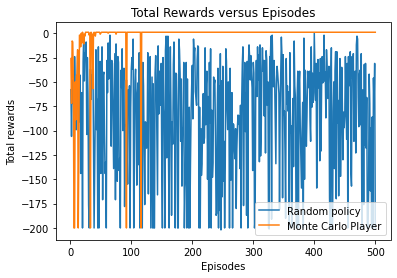

In [11]:
def playGridWorld(agent, xDim, yDim, numBlocks, transitProb, episodes=500, gamma = 0.8):
    """playGridWorld function:
                arguments: 
                agent: (object) the agent: Agent(random policy) or MonteCarloPlayer
                xDim, yDim: (int) height and width dimensions of the grid
                numBlocks: (int) number of blocked positions
                transitProb: (float) transition probability...between 0 and 1
                episodes: (int) number of episodes to play 
                gamma: (float) Discount factor for future rewards, between 0 and 1
    """
    agentName = "Random policy" if agent == Agent else "Monte Carlo Player"
    print("Playing with {}".format(agentName))
    totalRewards = []
    env = Environment(xDim, yDim, numBlocks, transitProb) #Create anvironment
    agent = agent(env.grid) #Create the agent 
    for i in range(episodes):
        env.reset()
        stateActionValues = []
        env.reset()
        presentState = env.state
        totalReward = 0
        t = 0
        while not presentState.isTerminal(): #Play until terminal state (Goal or Fire)
            t+= 1
            action = agent.getAction(presentState, i) #Agent takes action based on the present state
            print("Action selected: {}".format(action))
            nextState = env.nextStep(action) #Environment returns the next state based on the action
            print("Reward: {}".format(nextState.reward))
            reward = nextState.reward #Reward is returned based on the next state  
            totalReward +=reward
            stateActionValues.append([presentState.loc, action, 0 , t]) #Append this experience gained 
            #to memory. this serves as the training set for the MonteCarloAgent
            for stateActionValue in stateActionValues:
                stateActionValue[2] += gamma**(t- stateActionValue[3])*reward #Update the discounted action 
                #value for every past state encountered 
                #print(stateActionValue)
            presentState = nextState #Update the state
            if t == 200: #End game if there is no terminal state in 200 moves
                break
        if env.goalAchieved():
            print("You got to the goal!")
        else:
            print("You lost")
        totalRewards.append(totalReward)
        print("Total score: {}".format(totalReward))
        print("Game over")
        agent.learn(stateActionValues)
    plt.plot(range(1, episodes+1), totalRewards, label = agentName)
    plt.xlabel("Episodes")
    plt.ylabel("Total rewards")
    plt.title("Total Rewards versus Episodes")
    
#randomPolicy = Agent()
#player = MonteCarloPlayer(grid)
playGridWorld(Agent, 6,6,2,1)
playGridWorld(MonteCarloPlayer, 6,6,2,1)
plt.legend()